In [1]:
from qiskit.quantum_info import Operator, Pauli 
from qiskit.circuit.library import CXGate, CZGate, HGate, SGate
from qiskit import QuantumCircuit, Aer

import numpy as np
from random import choices
from numpy.random import permutation
import matplotlib.pyplot as plt
from itertools import product

The `operator` class has a lot of nice features. This cell sets up some useful operator-related functions.

In [25]:
#convenient names for common operators
I = Operator(np.identity(2))
H = Operator(HGate())
CX = Operator(CXGate())
CZ = Operator(CZGate())
X = Operator(Pauli('X'))
Y = Operator(Pauli('Y'))
Z = Operator(Pauli('Z'))
S = Operator(SGate())
IH = I.tensor(H)
HI = H.tensor(I)

#dimension of the system
n = 2

#iterate through all pauli strings and convert them to operators. indices are a convenient representation of ops
names = ["".join(str) for str in product(['I', 'X', 'Y','Z'], repeat=n)]
paulis = [Operator(Pauli(name)) for name in names]

#match pauli names with operators, so pauli_dict[name] = Operator(Pauli(name))
pauli_dict = dict(zip(names, paulis))

#give this function a pauli matrix and it returns its name if it is on the list, e.g. "XIYZ"
def get_name(pauli_op):
    try:
        #iterate through gates and check if they are equivalent up to global phase
        return names[min([i for (i,gate) in enumerate(paulis) if pauli_op.equiv(gate)])]
    except:
        return -1

#simplifying conjugating a pauli by a clifford
def conjugate(op1, op2):
    return op2.compose(op1).compose(op2.adjoint())

#get a random pauli of a specified weight
def sample_pauli(weight):
    if weight > n:
        return -1
    return pauli_dict["".join(permutation(choices(['X', 'Y','Z'], k=weight)+['I']*(n-weight)))]

In [199]:
def generate_paulis(adjacency_list, proc_size):
    pauli_list = []
    idPauli = ['I']*proc_size
    
    for i in range(proc_size):
        for op in ['X','Y','Z']:
            pauli = idPauli.copy()
            pauli[i] = op
            pauli_list.append("".join(pauli))

    for (qubit1, qubit2) in adjacency_list:
        for pauli1, pauli2 in product(['X','Y','Z'], repeat =2):
            pauli = idPauli.copy()
            pauli[qubit1] = pauli1
            pauli[qubit2] = pauli2
            pauli_list.append("".join(pauli))

    return pauli_list
    


In [201]:
#create a small two-qubit model to begin testing
small_proc = [(0,1)]
pauli_group = generate_paulis(small_proc, 2)
print(pauli_group)

['XI', 'YI', 'ZI', 'IX', 'IY', 'IZ', 'XX', 'XY', 'XZ', 'YX', 'YY', 'YZ', 'ZX', 'ZY', 'ZZ']


In [446]:
BASIS_CHANGE = {'I':I, 'Z':I, 'X':H, 'Y':H.compose(S)}

def change_basis_back(pauli_str):
    op = Operator([1])
    for char in pauli_str:
        op = op.tensor(BASIS_CHANGE[char])
    return op

def change_basis(pauli_str):
    op = Operator([1])
    for char in pauli_str:
        op = op.tensor(BASIS_CHANGE[char].adjoint())
    return op

def pauli_eigenstate_prep_ops(pauli_str):
    pos_ops, neg_ops = z_eigenstate_prep_ops(pauli_str)
    pos_ops = [op.compose(change_basis(pauli_str)) for op in pos_ops]
    neg_ops = [op.compose(change_basis(pauli_str)) for op in neg_ops]
    return (pos_ops, neg_ops)

def z_eigenstate_prep_ops(pauli_str):
    if len(pauli_str) == 1:
        return {'I':([I,X],[])}.get(pauli_str, ([I],[X]))
    last = z_eigenstate_prep_ops(pauli_str[-1])
    rest = z_eigenstate_prep_ops(pauli_str[:-1])
    ret_pos = [op2.tensor(op1) for op1 in last[0] for op2 in rest[0]]+[op2.tensor(op1) for op1 in last[1] for op2 in rest[1]]
    ret_neg = [op2.tensor(op1) for op1 in last[1] for op2 in rest[0]]+[op2.tensor(op1) for op1 in last[0] for op2 in rest[1]]
    return (ret_pos, ret_neg)


In [487]:
change_basis_back("IX").data @ pauli_eigenstate_prep_ops("IX")[0][1].data @ [[1],[0],[0],[0]]

array([[ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [ 1.00000000e+00+0.j],
       [-2.23711432e-17+0.j]])

## Measurement procedure

In [190]:
pauli = pauli_group[0]
gate_to_benchmark = CZ
prep_circuits_pos, prep_circuits_neg = pauli_eigenstate_prep_ops('XX')

def count_to_val(count):
    return -2*(count.count('1') % 2)+1

from qiskit.providers.aer.noise import depolarizing_error, NoiseModel
from qiskit import execute

p = .01
num = len(pauli_group)
onequbit_error = depolarizing_error(p, 1)
twoqubit_error = depolarizing_error(p, 2)
error_model = NoiseModel()
error_model.add_all_qubit_quantum_error(onequbit_error, ['id','rz', 'sx', 'u1', 'u2', 'u3'])
error_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])
basis_gates = error_model.basis_gates

def get_expectation(circuit):
    SHOTS = 10000
    backend = Aer.get_backend('qasm_simulator')
    circ = circuit.copy()
    circ.measure_all()
    counts = execute(circ, backend, shots = SHOTS, noise_model = error_model, basis_gates = basis_gates, optimization_level=0).result().get_counts()
    return np.sum([count_to_val(count)*counts[count]/SHOTS for count in counts.keys()])

In [483]:
def measure_fidelity(pauli, folds):
    dim = len(pauli)
    op_dim = int(np.log2(gate_to_benchmark.dim[0]))
    prep_circuits_pos, prep_circuits_neg = pauli_eigenstate_prep_ops(pauli)
    total = 0
    for circ in prep_circuits_pos:
        qc = QuantumCircuit(dim)
        qc.append(circ,range(dim))
        #for i in range(folds):
        #    qc.append(gate_to_benchmark, range(op_dim))
        #    qc.append(gate_to_benchmark, range(op_dim))
        qc.append(change_basis_back(pauli),range(dim))
        total += get_expectation(qc)
    for circ in prep_circuits_neg:
        qc = QuantumCircuit(dim)
        qc.append(circ,range(dim))
        #for i in range(folds):
        #    qc.append(gate_to_benchmark, range(op_dim))
        #    qc.append(gate_to_benchmark, range(op_dim))
        qc.append(change_basis_back(pauli),range(dim))
        #total -= get_expectation(qc)

    return total*1/2**dim

def exp(x,a):
    return np.exp(-a*x)

from scipy.optimize import curve_fit

def fit_fidelity(pauli, max_folds, precision):
    fidelities = []
    for folds in range(0,max_folds,precision):
        fidelities.append(measure_fidelity(pauli, folds))
    fidelities = [fid/fidelities[0] for fid in fidelities]
    xrange = range(0,max_folds*2, precision*2)
    popt, pcov = curve_fit(exp, xrange, fidelities, p0=[.01])
    return popt, fidelities

def progressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    # Displays a nice progress bar
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    if iteration == total: 
        print()

def generate_full_fidelity_list(max_folds, precision):
    fidelities = []
    progressBar(0, len(pauli_group))
    for i,pauli in enumerate(pauli_group):
        fidelities.append(fit_fidelity(pauli, max_folds, precision)[0][0])
        progressBar(i+1, len(pauli_group))
    #return np.exp(np.multiply(-1, fidelities))
    return fidelities

In [482]:
measure_fidelity("XI", 0)

-0.0008500000000000174

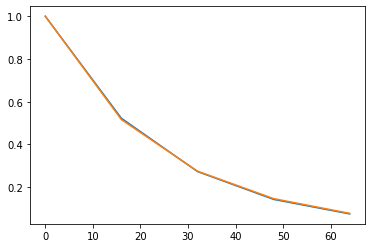

In [452]:
prec = 8
coeffs, fidelities = fit_fidelity("YZ", 40, prec)

xrange = range(0,80, prec*2)
plt.plot(xrange, [exp(x,coeffs[0]) for x in xrange])
plt.plot(xrange, fidelities)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


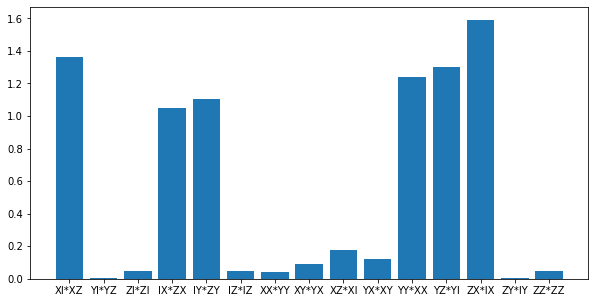

In [213]:
f = generate_full_fidelity_list(40, 8)
p_group_permuted = [get_name(conjugate(pauli_dict[pauli], gate_to_benchmark)) for pauli in pauli_group]
fig, ax = plt.subplots()
ax.bar(range(len(pauli_group)), f)
ax.set_xticks(range(len(pauli_group)), [p1+"*"+p2 for p1,p2 in zip(pauli_group, p_group_permuted)]);
fig.set_size_inches(10, 5, forward=True)

In [195]:
import scipy

def s_prod(a,b):
    return {True:0, False:1}[Pauli(a).commutes(Pauli(b))]

M1 = [[s_prod(a,b) for a in pauli_group] for b in pauli_group]
M2 = [[s_prod(a,b) for a in p_group_permuted] for b in pauli_group]
M = np.add(M1, M2)

model_coeffs, fit = scipy.optimize.nnls(M, -.5*np.log(f)) 
print(model_coeffs)

[0.         0.0031181  0.00147964 0.00315117 0.         0.
 0.00299037 0.0013718  0.00311824 0.00315633 0.         0.
 0.00280727 0.         0.        ]
